<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/02_%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD_%D0%B0%D0%BA%D1%86%D0%B8%D0%B9_(DNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Предсказание цен акций (DNN)**

# 1 Dense и Conv1D сети

## 1.1 Постановка задачи № 1

*Подготовьте нейросеть, предназначенную для прогнозирования акций Лукойла на 1 шаг с помощью Dense и Conv1D сетей (две отдельные сети).*

## 1.2 Подгрузка библиотек и подключение диска

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils                         # Для to_categorical
import numpy as np

from tensorflow.keras.optimizers import Adam               # Оптимизатор
from tensorflow.keras.models import Sequential, Model      # Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM     # Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler                                                                # Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator                                                       # Для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1.3 Подгрузка базы

In [ ]:
base_data = pd.read_csv('/content/drive/My Drive/HW_20/18_19.csv', sep=';')

In [ ]:
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
# Выцепялем numpy значения .values и выводим нулевую строку:
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/HW_20/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/HW_20/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data16_17.shape[0]

263925

In [ ]:
# Выводим параметры одного файла:
d = data18_19
print(len(d))          # Количество записей
print(len(d.iloc[0]))  # Длина одной строки
print(d.iloc[0])       # Пример (первая строка)

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# Объединяем базы из двух файлов:
data = data16_17.copy()                 # Создаем копию первой базы
data = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу
data = np.array(data)                   # Превращаем в numpy массив

In [ ]:
# Сравниваем размеры:
print(len(data16_17)) # Выводим размер первой базы
print(len(data18_19)) # Выводим размер второй базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
481872


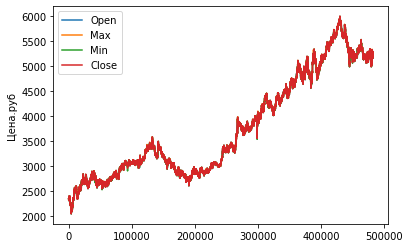

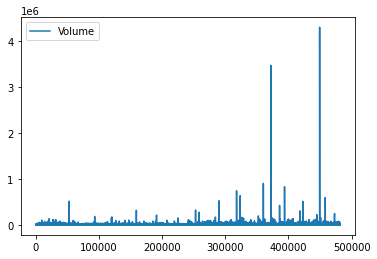

In [ ]:
# Отображаем исходные от точки start и длинной step:
start = 0             # С какой точки начинаем
step = data.shape[0]  # Сколько точек отрисуем

# Заполняем текстовые названия каналов данных:
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Рисуем все графики данных (четыре основных канала - open, max, min, close):
for i in range(4):
  # Отрисовываем часть данных (от начальной точки, до начальной точки + размер шага отрисовки):
  plt.plot(data[start:start+step,i],
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

# Канал volume:
plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

## 1.4 Функция загрузки данных

In [ ]:
# Формируем параметры загрузки данных:

xLen = 300                      # Анализируем по 300 прошедшим точкам
valLen = 30000                  # Используем 30 000 записей для проверки

trainLen = data.shape[0] - valLen # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки:
xTrain, xTest = data[:trainLen], data[trainLen + xLen + 2:]

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить нейросети:
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

# Делаем reshape, т.к. у нас только один столбец по одному значению:
yTrain, yTest = np.reshape(data[:trainLen, 3],(-1, 1)), np.reshape(data[trainLen + xLen + 2:, 3],(-1, 1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

# Создаем генератор для обучения:
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           # В качестве параметров наши выборки
                               length = xLen, stride = 1,    # Для каждой точки (из промежутка длины xLen)
                               batch_size = 20)

# Создаем аналогичный генератор для валидации при обучении:
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length = xLen, stride = 1,
                               batch_size = 20)

In [ ]:
yTrain[0]

array([0.07810564])

In [ ]:
xTrain[0]

array([0.07839171, 0.07822035, 0.07839814, 0.07810564, 0.00059283])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 1)


## 1.5 Функции визуализации данных

In [ ]:
# Функция рассчитываем результаты прогнозирования сети.
# В аргументы принимает сеть (currModel) и проверочную выборку.
# Выдаёт результаты предсказания predVal
# и правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования).

def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # и возвращаем исходны масштаб данных, до нормализации:
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы.
# start   - точка с которой начинаем отрисовку графика.
# step    - длина графика, которую отрисовываем.
# channel - какой канал отрисовываем.
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start + step, 0],
           label = 'Прогноз')
  plt.plot(yValUnscaled[start:start + step, channel],
           label = 'Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

# Функция расёта корреляции дух одномерных векторов:
def correlate(a, b):
  # Рассчитываем основные показатели:
  ma = a.mean()      # Среднее значение первого вектора
  mb = b.mean()      # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std()       # Среднеквадратичное отклонение первого вектора
  sb = b.std()       # Среднеквадратичное отклонение второго вектора

  # Рассчитываем корреляцию:
  val = 1
  if ((sa > 0) & (sb > 0)):
    val = (mab - ma * mb) / (sa * sb)
  return val

# Функция - рисуем корреляцию прогнозированного сигнала с правильным (?),
# смещая на различное количество шагов назад.
# Для проверки появления эффекта автокорреляции:
# channels  - по каким каналам отображать корреляцию;
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции.
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам:
  for ch in channels:
    corr = []                     # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0]  # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист:
      corr.append(correlate(yValUnscaled[:yLen - i, ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист:
      own_corr.append(correlate(yValUnscaled[:yLen - i, ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага:
    plt.plot(corr, label = 'Предсказание на ' + str(ch + 1) + ' шаг')
    plt.plot(own_corr, label = 'Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length = 300, stride = 1,
                               batch_size = len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## 1.6 Создание и обучение нейросетей

**1.6.1 Dense-сеть**

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 300, 150)          900       
_________________________________________________________________
flatten_17 (Flatten)         (None, 45000)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 45001     
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
22579/22579 [==============================] - 53s 2ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 2/20
22579/22579 [==============================] - 52s 2ms/step - loss: 1.3296e-04 - val_loss: 2.0712e-04
Epoch 3/20
22579/22579 [==============================] - 52s 2ms/step - loss: 7.5554e-05 - val_loss: 1.7770e-05
Epoch 4/20
22579/22579 [========================

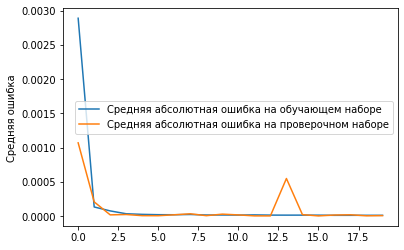

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen, 5), activation = "linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation = "linear"))

#Компилируем
modelD.compile(loss = "mse", optimizer = Adam(lr = 1e-4))

modelD.summary()

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen,
                    epochs = 20,
                    verbose = 1,
                    validation_data = testDataGen
                    )

#Выводим графики
plt.plot(history.history['loss'],
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

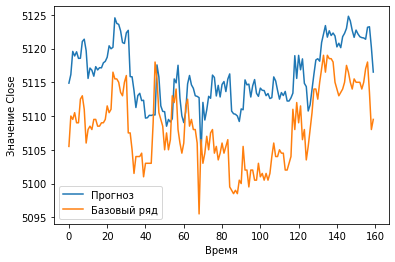

In [ ]:
# Прогнозируем данные текущей сетью:
currModel = modelD # Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) # Прогнозируем данные

# Отображаем графики:
showPredict(0, 160, 0, predVal, yValUnscaled)

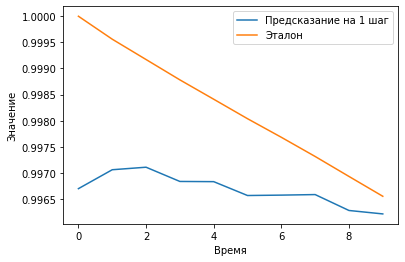

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

**1.6.2 Conv1D-сеть**

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 296, 200)          5200      
_________________________________________________________________
flatten_18 (Flatten)         (None, 59200)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               5920100   
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 101       
Total params: 5,925,401
Trainable params: 5,925,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
22579/22579 [==============================] - 71s 3ms/step - loss: 0.0272 - val_loss: 1.4887e-04
Epoch 2/20
22579/22579 [==============================] - 71s 3ms/step - loss: 0.0021 - val_loss: 5.5256e-05
Epoch 3/20
22579/22579 

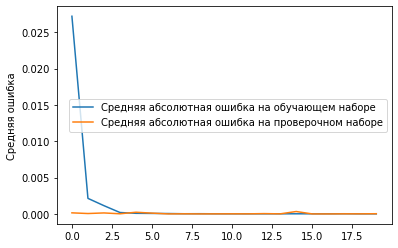

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen, 5), activation = "linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation = "linear"))
modelC.add(Dense(1, activation = "linear"))

modelC.compile(loss = "mse", optimizer = Adam(lr = 1e-4))
modelC.summary()

history = modelC.fit_generator(trainDataGen,
                    epochs = 20,
                    verbose = 1,
                    validation_data = testDataGen)

plt.plot(history.history['loss'],
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

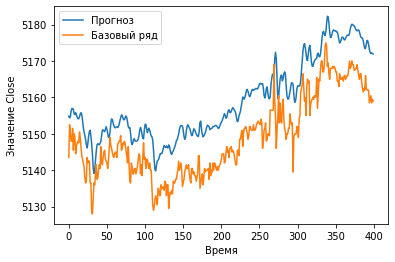

In [ ]:
#Отображаем графики
showPredict(300, 400, 0, predVal - 5, yValUnscaled)

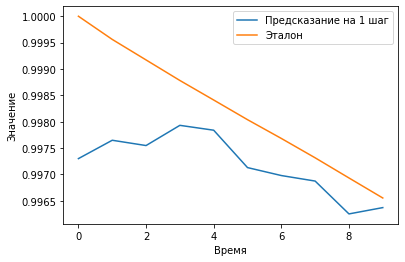

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## 1.7 Выводы

Подготовлены и обучены две нейронные сети, предназначенные для предсказания стоимости акций ПАО "Лукойл" на основе сведений об акциях за предыдущие 300 минут.

# 2 Автокорреляция

## 2.1 Постановка задачи № 2

*Сделайте сеть с предсказанием на один шаг и valLen = 30000 так, чтобы корреляция на старте была 99,9% и строго убывала.*

## 2.2 Создание и обучение нейронной сети

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 296, 50)           1300      
_________________________________________________________________
flatten_16 (Flatten)         (None, 14800)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                148010    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 149,321
Trainable params: 149,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
22579/22579 [==============================] - 49s 2ms/step - loss: 0.0013 - val_loss: 8.7552e-05
Epoch 2/20
22579/22579 [==============================] - 47s 2ms/step - loss: 2.4863e-04 - val_loss: 2.7432e-05
Epoch 3/20
22579/22579 

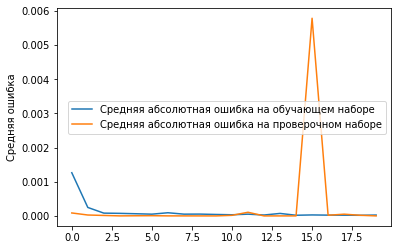

In [ ]:
#Создаём нейронку
model_P_4 = Sequential()

model_P_4.add(Conv1D(50, 5, input_shape = (xLen,5), activation="linear"))
model_P_4.add(Flatten())
model_P_4.add(Dense(10, activation="linear"))
model_P_4.add(Dense(1, activation="linear"))


#Компилируем
model_P_4.compile(loss = "mse", optimizer = Adam(lr = 1e-4))

model_P_4.summary()

#Запускаем обучение
history = model_P_4.fit_generator(
                    trainDataGen,
                    epochs = 20,
                    verbose = 1,
                    validation_data = testDataGen
                    )

#Выводим графики
plt.plot(history.history['loss'],
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

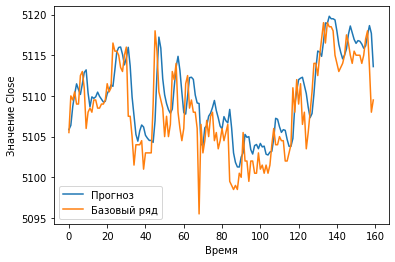

In [ ]:
# Прогнозируем данные текущей сетью:
currModel = model_P_4 # Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) # Прогнозируем данные

# Отображаем графики:
showPredict(0, 160, 0, predVal, yValUnscaled)

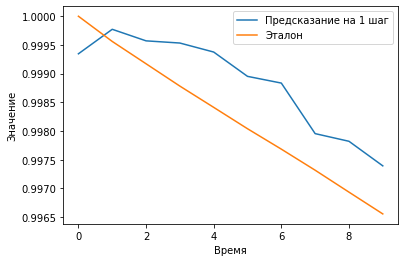

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

## 2.3 Выводы

Подготовлена и обучена нейронная сеть, предназначенная для предсказания стоимости акций ПАО "Лукойл" на основе сведений об акциях за предыдущие 300 минут. Стартовое значение граффика корреляции равно примерно 0,9994.

Далее график возрастает примерно до 0,9998, после чего строго убывает.

Для обеспечения стабильного уменьшения значений графика корреляции целесообразно сделать следуюющее:
- добавить слой LSTM;
- убрать слой flatten (т.к. затирает временную зависимость);
- поэксперементировать с количеством нейронов на входе;
- поэксперементировать с добавлением Conf1D слоёв.